## **Catégorisez automatiquement des questions**

### partie 4/8 : Prédiction de tags, approche supervisée + tracking mlflow

#### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## Import librairies


In [1]:
import os
import numpy as np
import pandas as pd
from typing import Tuple
import json
import requests


from pprint import pprint
import matplotlib.pyplot as plt

import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature, ModelSignature, Schema, ParamSchema
from mlflow.types import Schema, ParamSchema, ParamSpec, ColSpec
# Pour Schema et ParamSchema on a le choix !

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


os.environ['MLFLOW_TRACKING_URI'] = './../mlruns'

# client = MlflowClient(tracking_uri="http://127.0.0.1:5000")


## mlfow basics : on localhost with tracking server, no database


### create mlflow experiment


In [2]:
# localhost + facile pour commencer, mais impossible de partager
# => tester ensuite avec remote tracking server, backend & artifact store

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


# create a new mlflow experiment
experiment_id = create_mlflow_experiment(
    experiment_name="testing_mlflow",
    artifact_location="testing_mlflow1_artifacts",
    tags={"env": "dev", "version": "1.0.0"},
)

print(experiment_id)


Experiment testing_mlflow already exists.
642640077049090575


### get mlflow experiment


In [3]:
def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


#retrieve the mlflow experiment
experiment = get_mlflow_experiment(experiment_id="434671109481285144")

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))


Name: testing_mlflow10
Experiment_id: 434671109481285144
Artifact Location: /home/ubuntu/Bureau/OC/Projet5_oudelet_kevin/notebooks/testing_mlflow1_artifacts
Tags: {'env': 'dev', 'version': '1.0.0'}
Lifecycle_stage: deleted
Creation timestamp: 1705138449722


In [4]:
# On peut aussi delete depuis l'ui

# mlflow.delete_experiment(experiment_id="434671109481285144")


### mlflow run


In [5]:
#start a new mlflow run
mlflow.start_run()

# Your machine learning code goes here
mlflow.log_param("learning_rate",0.01)

#end the mlflow run
mlflow.end_run()


In [6]:
# cleaner
with mlflow.start_run(run_name="test_run") as run:

        # Your machine learning code goes here
        mlflow.log_param("learning_rate",0.02)
        print(f"RUN ID : {run.info.run_id}", '\n')

        print(run.info)


RUN ID : dbcfdfec89d84d21b21f4539815d2e16 

<RunInfo: artifact_uri='/home/ubuntu/Bureau/OC/Projet5_oudelet_kevin/notebooks/testing_mlflow1_artifacts/dbcfdfec89d84d21b21f4539815d2e16/artifacts', end_time=None, experiment_id='642640077049090575', lifecycle_stage='active', run_id='dbcfdfec89d84d21b21f4539815d2e16', run_name='test_run', run_uuid='dbcfdfec89d84d21b21f4539815d2e16', start_time=1705308157996, status='RUNNING', user_id='ubuntu'>


In [7]:
# attribuer le run au bon experiment :
# possible avec mlflow.set_experiment(experiment_name=experiment_name)
# ou directement avec un param de la méthode mlflow.start_run, experiment_id ou experiment_name  :

experiment_id = create_mlflow_experiment(
    experiment_name="another_test",
    artifact_location="testing_mlflow42_artifacts",
    tags={"env": "dev", "version": "1.0.0"},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))
with mlflow.start_run(run_name="testing", experiment_id=experiment_id) as run:

    # Your machine learning code goes here
    mlflow.log_param("learning_rate",0.42)
    # print run info
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


Experiment another_test already exists.
Name: another_test
run_id: 7d6ab19f55e641bd8857621fa950b7d2
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158118
end_time: None
lifecycle_stage: active


## Logging


### params


In [8]:
# log params using a dict

with mlflow.start_run(run_name="logging_params", experiment_id=experiment_id) as run:

    # Your machine learning code goes here
    parameters = {
        "learning_rate": 0.02,
        "epochs": 10,
        "batch_size": 100,
        "loss_function": "mse",
        "optimizer": "adam"
    }

    mlflow.log_params(parameters)

    # print run info
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))



run_id: 330f28a127354218a1c4fe01b47b29c4
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158132
end_time: None
lifecycle_stage: active


### metrics


In [9]:
# log metrics

with mlflow.start_run(run_name="logging_metrics", experiment_id=experiment_id) as run:
        # Your machine learning code goes here

        # single metric
        mlflow.log_metric("random_metric", 0.01)

        metrics = {
            "mse": 0.01,
            "mae": 0.01,
            "rmse": 0.01,
            "r2": 0.01
        }

        # multiple metrics
        mlflow.log_metrics(metrics)

        # print run info
        print("run_id: {}".format(run.info.run_id))
        print("experiment_id: {}".format(run.info.experiment_id))
        print("status: {}".format(run.info.status))
        print("start_time: {}".format(run.info.start_time))
        print("end_time: {}".format(run.info.end_time))
        print("lifecycle_stage: {}".format(run.info.lifecycle_stage))



run_id: 891f45bdff0e49d2b374ba77b755cdc7
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158148
end_time: None
lifecycle_stage: active


### artefacts


In [10]:
# log artefacts

with mlflow.start_run(run_name="logging_artifacts", experiment_id=experiment_id) as run:

    # your machine learning code goes here

    # create a text file that says hello world
    with open("hello_world.txt", "w") as f:
        f.write("Hello World!")

    # log the text file as an artifact
    mlflow.log_artifact(local_path="hello_world.txt", artifact_path="text_files")

    # print run info
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


run_id: 8aff12a572d6421f856e22857b62ebb4
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158164
end_time: None
lifecycle_stage: active


In [11]:
# log multiple artifacts in a folder

with mlflow.start_run(run_name="logging_artifacts", experiment_id=experiment_id) as run:

    # your machine learning code goes here

    mlflow.log_artifacts(local_dir="./run_artifacts",artifact_path="run_artifacts")

    # print run info
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


run_id: b0131b44471b44f09dff32099569bb6b
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158178
end_time: None
lifecycle_stage: active


### images


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


run_id: 65596df5763848c09deb8a4e3ef09d09
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158194
end_time: None
lifecycle_stage: active


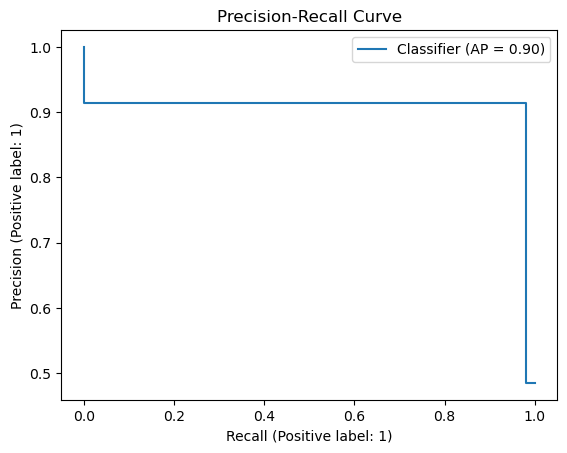

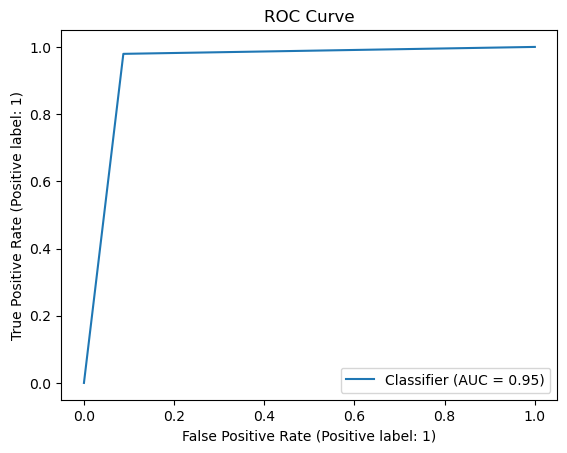

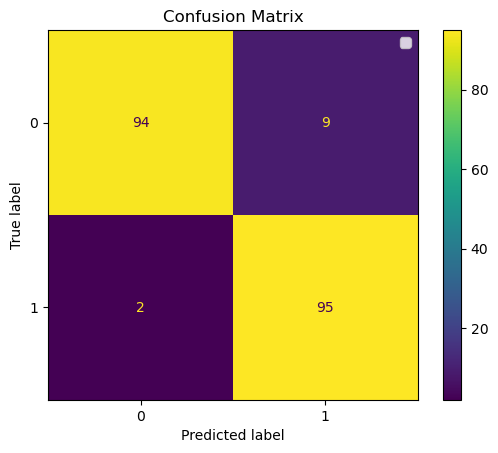

In [12]:
# log images

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

with mlflow.start_run(run_name="logging_images", experiment_id=experiment_id) as run:

    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    # log the precision-recall curve
    fig_pr = plt.figure()
    pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=plt.gca())
    plt.title("Precision-Recall Curve")
    plt.legend()

    mlflow.log_figure(fig_pr, "metrics/precision_recall_curve.png")

    # log the ROC curve
    fig_roc = plt.figure()
    roc_display = RocCurveDisplay.from_predictions(y_test, y_pred, ax=plt.gca())
    plt.title("ROC Curve")
    plt.legend()

    mlflow.log_figure(fig_roc, "metrics/roc_curve.png")

    # log the confusion matrix
    fig_cm = plt.figure()
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.legend()

    mlflow.log_figure(fig_cm, "metrics/confusion_matrix.png")

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


### models


In [13]:
# log a model
# no autolog here

with mlflow.start_run(run_name="logging_model", experiment_id=experiment_id) as run:

    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # log model using autolog
    # mlflow.autolog()
    # mlflow.sklearn.autolog()

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    # log model
    mlflow.sklearn.log_model(sk_model=rfc, artifact_path="random_forest_classifier")

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


run_id: 136c202324ed4284af6d056a7130892e
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308158931
end_time: None
lifecycle_stage: active


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Autolog


In [14]:
# autolog

with mlflow.start_run(run_name="autolog", experiment_id=experiment_id) as run:

    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # log model using autolog
    mlflow.autolog()
    # mlflow.sklearn.autolog()

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    # log model
    # mlflow.sklearn.log_model(sk_model=rfc, artifact_path="random_forest_classifier")

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


# Ok now we're talking !
# This is getting interesting


2024/01/15 09:42:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


run_id: c0aeba32241b413abb4b8bd4eb311f4b
experiment_id: 571942391625670656
status: RUNNING
start_time: 1705308161042
end_time: None
lifecycle_stage: active


## Load a model


In [15]:
run_id = '2c357c456d164cc8b45e0634489dc54e'

X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X = pd.DataFrame(X, columns=["feature_{}".format(i) for i in range(10)])
y = pd.DataFrame(y, columns=["target"])

_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# load model
# model_uri = f'runs:/{run_id}/random_forest_classifier'
model_uri = f"/home/ubuntu/Bureau/OC/Projet5_oudelet_kevin/notebooks/testing_mlflow42_artifacts/{run_id}/artifacts/random_forest_classifier"

rfc = mlflow.sklearn.load_model(model_uri=model_uri)

y_pred = rfc.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=["prediction"])

print(y_pred.head())



   prediction
0           0
1           0
2           0
3           1
4           0


## Nested runs


In [16]:
experiment_id = create_mlflow_experiment(
    experiment_name= "Nested Runs",
    artifact_location= "nested_run_artifacts",
    tags={"purpose":"learning"}
)


with mlflow.start_run(run_name="parent") as parent:
    print("RUN ID parent:", parent.info.run_id)

    mlflow.log_param("parent_param", "parent_value")

    with mlflow.start_run(run_name="child1",nested=True) as child1:
        print("RUN ID child1:", child1.info.run_id)
        mlflow.log_param("child1_param", "child1_value")

        with mlflow.start_run(run_name="child_11", nested=True) as child_11:
            print("RUN ID child_11:", child_11.info.run_id )
            mlflow.log_param("child_11_param", "child_11_value")

        with mlflow.start_run(run_name="child_12", nested=True) as child_12:
            print("RUN ID child_12:", child_12.info.run_id)
            mlflow.log_param("child_12_param", "child_12_value")

    with mlflow.start_run(run_name="child2", nested=True) as child2:
        print("RUN ID child2:", child2.info.run_id)
        mlflow.log_param("child2_param", "child2_value")


Experiment Nested Runs already exists.
RUN ID parent: a878d60f46264ce4a887e8c930eace56
RUN ID child1: 5d7bc34df585444dbaabd2a9c1f1949b
RUN ID child_11: ffd05018d167471c939cf47a7f2a8baf
RUN ID child_12: 38cd0869ca654732aef524db602ebfc8
RUN ID child2: bf37eb90f165488abddcbaf3d4cce38d


## Custom models


In [17]:
class CustomModel(mlflow.pyfunc.PythonModel):

    def __init__(self):
        pass

    # ! fit and predict fonctions are required
    def fit(self):
        print("Fitting model...")

    def predict(self, context, model_input:[str]):
        return self.get_prediction(model_input)

    # other functions, anything we want
    def get_prediction(self, model_input:[str]):
        # do something with the model input
        return " ".join([w.upper() for w in model_input])


experiment_id = create_mlflow_experiment(
    experiment_name= "Custom Models",
    artifact_location= "custom_model_artifacts",
    tags={"purpose":"learning"}
)

with mlflow.start_run(run_name="custom_model_run") as run:
    custom_model = CustomModel()

    custom_model.fit()

    mlflow.pyfunc.log_model(
        artifact_path="custom_model",
        python_model=custom_model)

    mlflow.log_param("param1", "value1")

    # load model using pyfunc flavor
    custom_model = mlflow.pyfunc.load_model(f"runs:/{run.info.run_id}/custom_model")

    prediction = custom_model.predict(["hello", "world"])
    print(prediction)


2024/01/15 09:42:43 INFO mlflow.types.utils: Unsupported type hint: [<class 'str'>], skipping schema inference


Experiment Custom Models already exists.
Fitting model...
HELLO WORLD


## Signature


In [18]:
# Manuelle, sans inference

def get_train_data() -> Tuple[pd.DataFrame]:
    """
    Generate train and test data.

    :return: x_train,y_train
    """
    x, y = make_classification()
    features = [f"feature_{i+1}" for i in range(x.shape[1])]
    df = pd.DataFrame(x, columns=features)
    df["label"] = y

    return df[features], df["label"]


x_train, y_train = get_train_data()
cols_spec = []
data_map = {
    'int64': 'integer',
    'float64': 'double',
    'bool': 'boolean',
    'str': 'string',
    "date": 'datetime'
}

for name, dtype in x_train.dtypes.to_dict().items():
    cols_spec.append(ColSpec(name=name, type=data_map[str(dtype)]))

input_schema = Schema(inputs=cols_spec)
output_schema = Schema([ColSpec(name="label", type="integer")])

parameter = ParamSpec(name="model_name", dtype="string", default="model1")
param_schema = ParamSchema(params=[parameter])

model_signature = ModelSignature(inputs=input_schema, outputs=output_schema, params=param_schema)
print("MODEL SIGNATURE")
print(model_signature.to_dict())

model_signature = infer_signature(x_train, y_train, params={"model_name": "model1"})
print("MODEL SIGNATURE")
print(model_signature.to_dict())

experiment_id = create_mlflow_experiment(
    experiment_name="Model Signature",
    artifact_location="model_signature_artifacts",
    tags={"purpose": "learning"},
)

with mlflow.start_run(run_name="model_signature_schemas") as run:
    mlflow.sklearn.log_model(
        sk_model=RandomForestClassifier(),
        artifact_path="model_signature",
        signature=model_signature,
    )


MODEL SIGNATURE
{'inputs': '[{"type": "double", "name": "feature_1"}, {"type": "double", "name": "feature_2"}, {"type": "double", "name": "feature_3"}, {"type": "double", "name": "feature_4"}, {"type": "double", "name": "feature_5"}, {"type": "double", "name": "feature_6"}, {"type": "double", "name": "feature_7"}, {"type": "double", "name": "feature_8"}, {"type": "double", "name": "feature_9"}, {"type": "double", "name": "feature_10"}, {"type": "double", "name": "feature_11"}, {"type": "double", "name": "feature_12"}, {"type": "double", "name": "feature_13"}, {"type": "double", "name": "feature_14"}, {"type": "double", "name": "feature_15"}, {"type": "double", "name": "feature_16"}, {"type": "double", "name": "feature_17"}, {"type": "double", "name": "feature_18"}, {"type": "double", "name": "feature_19"}, {"type": "double", "name": "feature_20"}]', 'outputs': '[{"type": "integer", "name": "label"}]', 'params': '[{"name": "model_name", "dtype": "string", "default": "model1", "shape": n

/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/mlflow/models/signature.py:215: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  outputs = _infer_schema(model_output) if model_output is not None else None


In [19]:
# quick, easy way

with mlflow.start_run(run_name="model_signature_inference", experiment_id=experiment_id) as run:

    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    X_train = pd.DataFrame(X_train, columns=["feature_{}".format(i) for i in range(10)])
    X_test = pd.DataFrame(X_test, columns=["feature_{}".format(i) for i in range(10)])
    y_train = pd.DataFrame(y_train, columns=["target"])
    y_test = pd.DataFrame(y_test, columns=["target"])

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=["prediction"])

    # infer signature
    model_signature = infer_signature(model_input=X_train, model_output=y_pred)


    # log model
    mlflow.sklearn.log_model(sk_model=rfc, artifact_path="random_forest_classifier", signature=model_signature)


    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


2024/01/15 09:42:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/mlflow/data/digest_utils.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/01/15 09:42:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/mlflow/data/digest_utils.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/mlflow/models/signature.py:215: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based o

run_id: a948eeb71cd0474b85407b2896c8a283
experiment_id: 985968209234505742
status: RUNNING
start_time: 1705308165704
end_time: None
lifecycle_stage: active


## Serving multiple models (to a single endpoint)


In [20]:
class CustomModel(mlflow.pyfunc.PythonModel):
    def predict_model1(self, model_input):
        # do some processing for model 1
        return 0 * model_input

    def predict_model2(self, model_input):
        # do some processing for model 2
        return model_input

    def predict_model3(self, model_input):
        # do some processing for model 3
        return 2 * model_input

    def predict(self, context, model_input, params):
        if params["model_name"] == "model_1":
            return self.predict_model1(model_input=model_input)

        elif params["model_name"] == "model_2":
            return self.predict_model2(model_input=model_input)

        elif params["model_name"] == "model_3":
            return self.predict_model3(model_input=model_input)

        else:
            raise Exception("Model Not Found!")


experiment_id = create_mlflow_experiment(
    experiment_name="Serving Multiple Models",
    artifact_location="serving_multiple_models",
    tags={"purpose": "learning"},
)
input_schema = Schema(inputs=[ColSpec(type="integer", name="input")])
output_schema = Schema(inputs=[ColSpec(type="integer", name="output")])
param_spec = ParamSpec(name="model_name", dtype="string", default=None)
param_schema = ParamSchema(params=[param_spec])
model_signature = ModelSignature(
    inputs=input_schema, outputs=output_schema, params=param_schema
)

with mlflow.start_run(run_name="multiple_models", experiment_id=experiment_id) as run:

    mlflow.pyfunc.log_model(artifact_path="model", python_model=CustomModel(), signature=model_signature)

    model_uri = f"runs:/{run.info.run_id}/model"
    loaded_model = mlflow.pyfunc.load_model(model_uri=model_uri)

    for n in range(3):
        print(f"PREDICTION FROM MODEL {n+1}")
        print(loaded_model.predict(data={"input":np.int32(10)}, params={"model_name":f"model_{n+1}"}))
        print("\n")

    print(f"RUN_ID: {run.info.run_id}")


Experiment Serving Multiple Models already exists.
PREDICTION FROM MODEL 1
   input
0      0


PREDICTION FROM MODEL 2
   input
0     10


PREDICTION FROM MODEL 3
   input
0     20


RUN_ID: 4937e93bb290414187691d210a479479


In [24]:
# !mlflow models serve --model-uri runs:/5248647db1964686a1ee222817ee57f7/model  --no-conda --port 5001


2024/01/15 10:36:36 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/01/15 10:36:36 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:5001 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-01-15 10:36:36 +0100] [48477] [INFO] Starting gunicorn 20.1.0
[2024-01-15 10:36:36 +0100] [48477] [INFO] Listening at: http://127.0.0.1:5001 (48477)
[2024-01-15 10:36:36 +0100] [48477] [INFO] Using worker: sync
[2024-01-15 10:36:36 +0100] [48478] [INFO] Booting worker with pid: 48478
^C
[2024-01-15 10:37:25 +0100] [48477] [INFO] Handling signal: int
[2024-01-15 10:37:25 +0100] [48478] [INFO] Worker exiting (pid: 48478)
